Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

Let's take the SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset for protein and ligand modeling and consists of 642 experimental values logP.

MMFDL_geneInput.ipynb is mainly used to generate the data iterator required for model training.

This figure shows the construction process of the input representation in detail. There are three different input representations, namely SMILSE-encoded vectors, ECFP fingerprints and Graph.

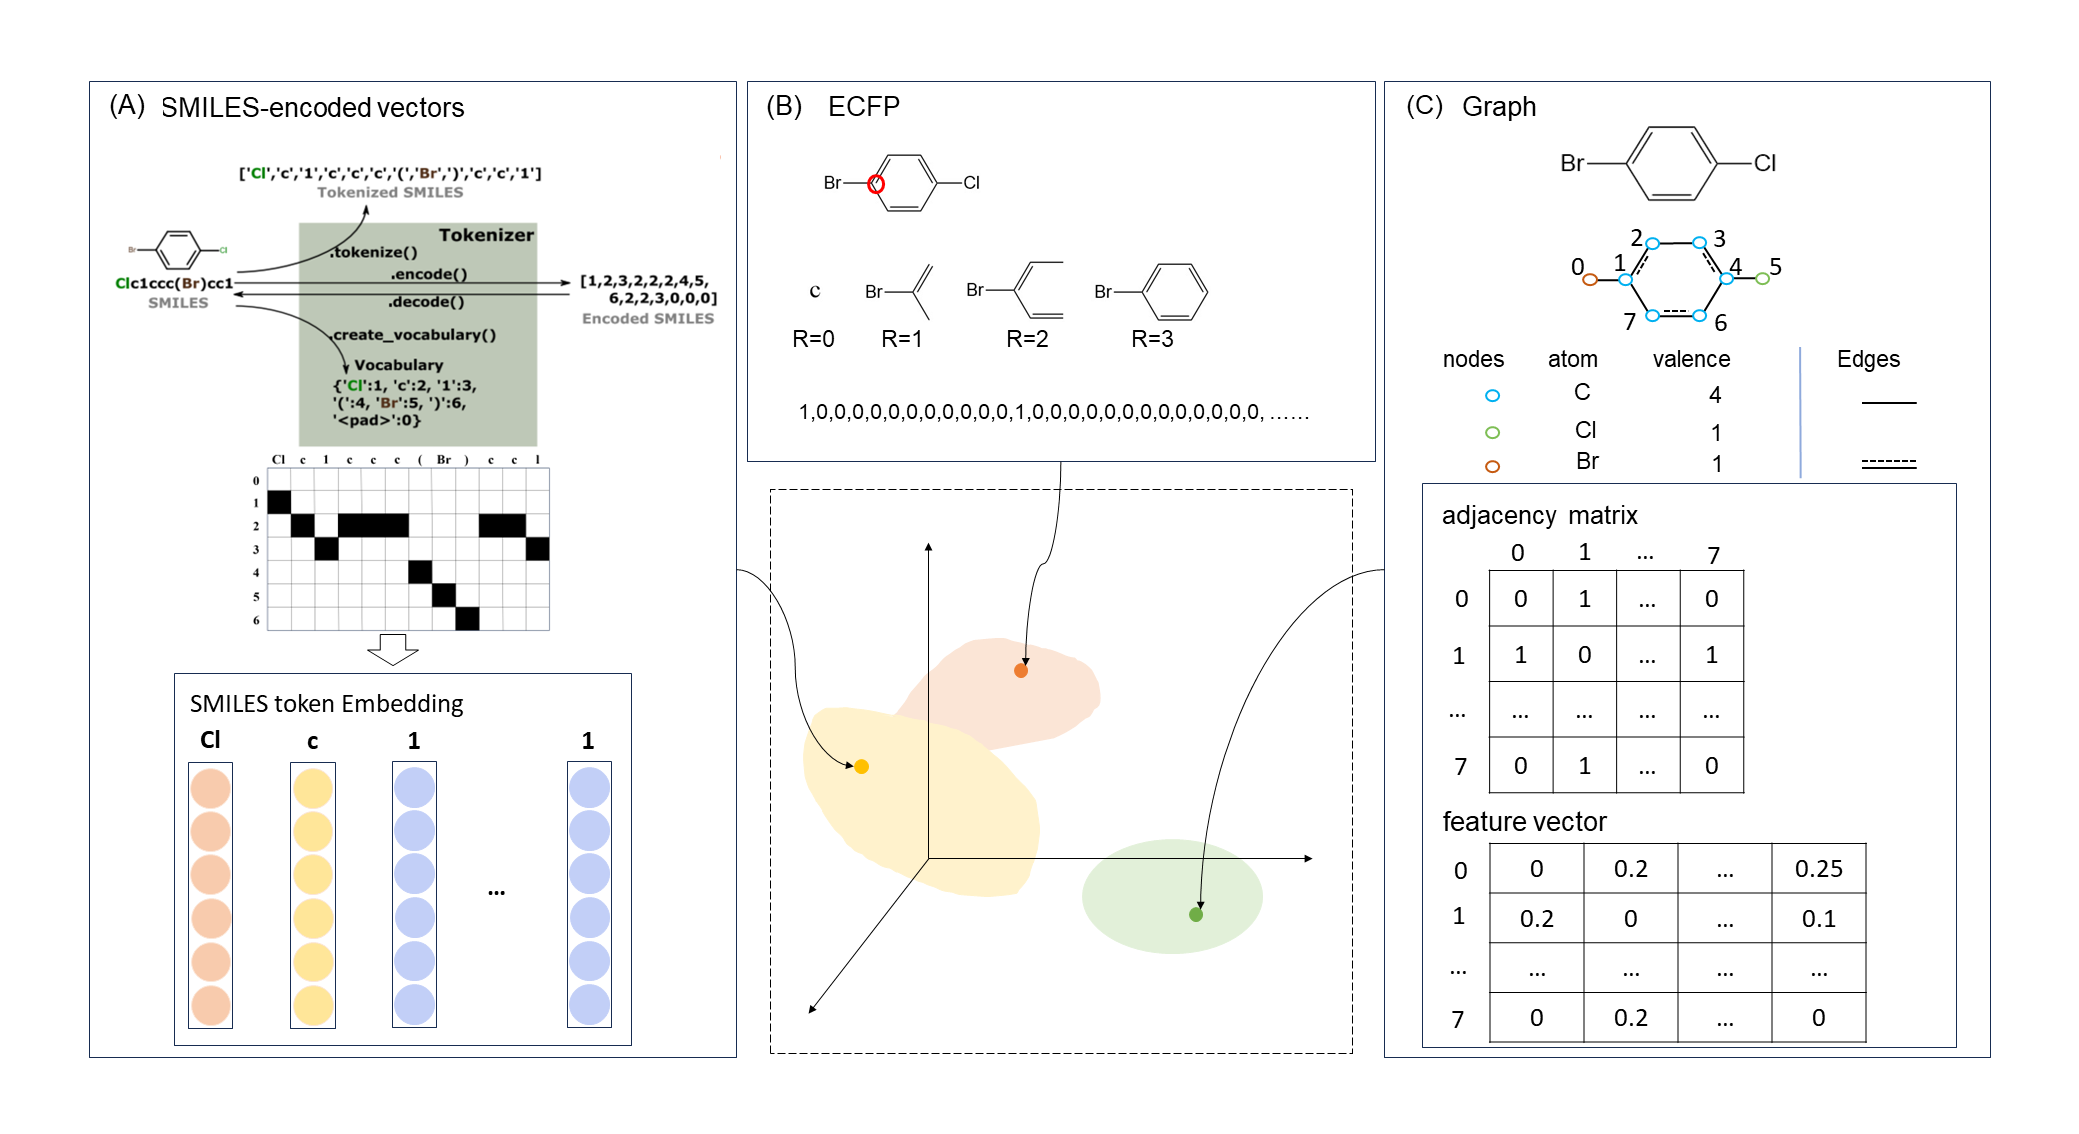

In [6]:
from PIL import Image
from IPython.display import display
img = Image.open('inputRepresentation.png')
display(img)


Extracting information

In [2]:
import pandas as pd

df = pd.read_csv('../dataSour/SAMPL.csv')
resultDic = {}
resultDic['smiles'] = df['smiles']
resultDic['exp'] = df['expt']

res = pd.DataFrame(resultDic)
res.to_csv('../dataSour/sampl_all.csv', index=False)

smilesAll = {'smiles': []}
for item in resultDic['smiles']:
    smilesAll['smiles'].append(item)

res= pd.DataFrame(smilesAll)
res.to_csv('../dataSour/dataSmileAll.txt', index=False, header=False)
print(pd.DataFrame(resultDic))
print(pd.DataFrame(smilesAll))

                     smiles    exp
0    CN(C)C(=O)c1ccc(cc1)OC -11.01
1              CS(=O)(=O)Cl  -4.87
2                  CC(C)C=C   1.83
3                CCc1cnccn1  -5.45
4                  CCCCCCCO  -4.21
..                      ...    ...
637          CCCCCCCC(=O)OC  -2.04
638                 C1CCNC1  -5.48
639          c1cc(ccc1C=O)O  -8.83
640               CCCCCCCCl   0.29
641                C1COCCO1  -5.06

[642 rows x 2 columns]
                     smiles
0    CN(C)C(=O)c1ccc(cc1)OC
1              CS(=O)(=O)Cl
2                  CC(C)C=C
3                CCc1cnccn1
4                  CCCCCCCO
..                      ...
637          CCCCCCCC(=O)OC
638                 C1CCNC1
639          c1cc(ccc1C=O)O
640               CCCCCCCCl
641                C1COCCO1

[642 rows x 1 columns]


Make the dictionary required for SMILES-encoded vectors

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import re
import sys
# from scripts.parsers import vocab_parser

def tokenizer(smile):
    "Tokenizes SMILES string"
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regezz = re.compile(pattern)
    tokens = [token for token in regezz.findall(smile)]
    assert smile == ''.join(tokens), ("{} could not be joined".format(smile))
    return tokens

def build_vocab(smiles, vocab_name='char_dict', save_dir=None):
    ### Build vocab dictionary
    print('building dictionary...')
    char_dict = {}
    char_idx = 1
    mol_toks = []
    with open(smiles, 'r') as f:
        for line in f:
            line = line.split('\n')[0]
            if line.lower() in ['smile', 'smiles', 'selfie', 'selfies']:
                pass
            else:
                mol = tokenizer(line)
                for tok in mol:
                    if tok not in char_dict.keys():
                        char_dict[tok] = char_idx
                        char_idx += 1
                    else:
                        pass
                mol.append('<end>')
                mol_toks.append(mol)

    ### Write dictionary to file
    with open(os.path.join(save_dir, vocab_name+'.pkl'), 'wb') as f:
        pickle.dump(char_dict, f)
    return char_dict
    
if __name__ == '__main__':
    filePath = '../dataSour/dataSmileAll.txt'
    file_name = 'smiles_char_dict'
    savePath = '../dataSour'
    char_dict = build_vocab(filePath, file_name, savePath)

    vocab_path = '../dataSour/smiles_char_dict.pkl'
    with open(vocab_path, 'rb') as f:
        smilesVoc = pickle.load(f)
    print(smilesVoc)

building dictionary...
{'C': 1, 'N': 2, '(': 3, ')': 4, '=': 5, 'O': 6, 'c': 7, '1': 8, 'S': 9, 'Cl': 10, 'n': 11, '[C@@H]': 12, '[C@H]': 13, 'Br': 14, '/': 15, '\\': 16, '2': 17, 'P': 18, '#': 19, 'F': 20, 'I': 21, '3': 22, '[N+]': 23, '[O-]': 24, '[nH]': 25, '[C@@]': 26, '[C@]': 27, '[S+2]': 28, 's': 29, '-': 30, '[N@@]': 31, '[N@]': 32, '4': 33, '5': 34}


Make dat file based on the sequence length of SMILES-encoded vectors

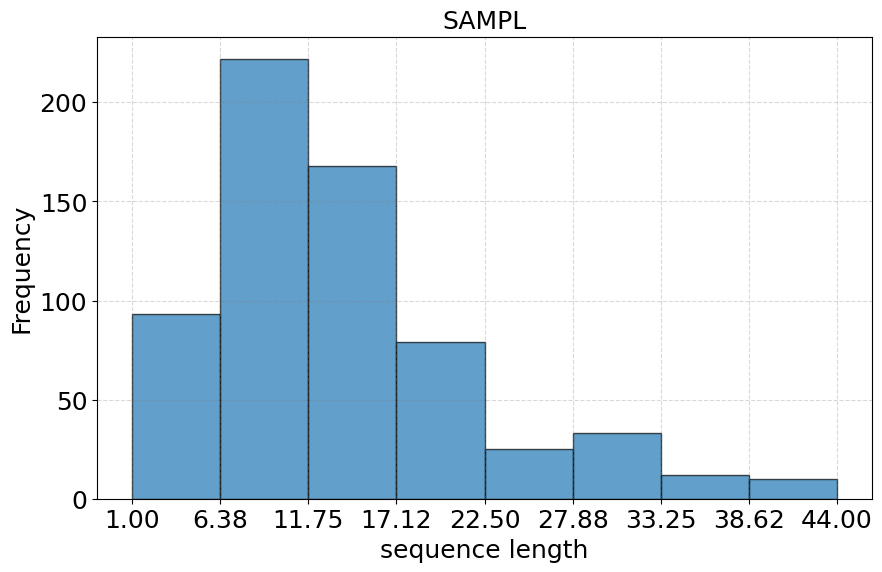

In [4]:
import matplotlib.pyplot as plt

def make_variable_length(smiles, letters):
    resultVec = []
    char_list = tokenizer(smiles)
    for item in char_list:
        resultVec.append(letters[item])
    return len(resultVec)

def pltSmiCurveDistribution_sample(filePath, smilesVoc, title):
    df = pd.read_csv(filePath)
    smiles = df['smiles'].tolist()
    seq_smiles = []
    for smi in smiles:
        seq_smiles.append(make_variable_length(smi, smilesVoc))
    num_bins = 8
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=18)
    n, bins, patches = plt.hist(seq_smiles, bins=num_bins, edgecolor='black', alpha=0.7)
    plt.xlabel('sequence length', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(bins, fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, linestyle='--', color='grey', alpha=0.3)
    plt.savefig('../result/sampl_smiles.png', dpi=600)
    plt.show()

if __name__ == '__main__':
    vocab_path = '../dataSour/smiles_char_dict.pkl'
    with open(vocab_path, 'rb') as f:
        smilesVoc = pickle.load(f)
    filePath = '../dataSour/SAMPL.csv'
    pltSmiCurveDistribution_sample(filePath, smilesVoc, 'SAMPL')

Create a dat file, which includes smi, SMILES-ecoded vectors, ECFP, and y. Among them, smi is the SMILES string; SMILES-encoded vectors are converted into numeric vectors according to the dictionary; y is the predicted value.

In [5]:
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
import random
import sys
sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from utils import *

def splitData_dat(filePath, smilesVoc):
    allData = []
    with open(filePath, "r") as dat_file:
        for line in dat_file:
            line = line.strip()
            elements = line.split(" ") 
            allData.append(elements)
    random.shuffle(allData)
    count = int(len(allData) / 7)
    dataTrain = []
    dataTest = []
    for i in range(count):
        for j in range(7):
            if j < 6:
                dataTrain.append(allData[i*7+j])
            else:
                dataTest.append(allData[i*7+j])


    savePath = '../dataSour/dataTrain.dat'
    with open(savePath, 'w') as dat_file:
        for row in dataTrain:
            smi = row[0]
            enSmi = make_variable_one(smi, smilesVoc, 44)
            enSmi = ','.join(map(str, enSmi))
            ep = row[1]
            exp = row[2]
            line = smi + ' ' + enSmi + ' ' + ep + ' ' + exp
            dat_file.write(line + '\n')
    print('writing ' + savePath + ' finished!')
    
    savePath = '../dataSour/dataTest.dat'
    with open(savePath, 'w') as dat_file:
        for row in dataTest:
            smi = row[0]
            enSmi = make_variable_one(smi, smilesVoc, 44)
            enSmi = ','.join(map(str, enSmi))
            ep = row[1]
            exp = row[2]
            line = smi + ' ' + enSmi + ' ' + ep + ' ' + exp
            dat_file.write(line + '\n')   
    print('writing ' + savePath + ' finished!')    


def check_ecfp(filePath):
    smiles = pd.read_csv(filePath)['smiles'].tolist()
    notGen = []
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol != None:
            if mol.HasSubstructMatch(Chem.MolFromSmarts("[H]")):
                mol = Chem.RemoveHs(mol)
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            if ecfp == None:
                notGen.append(smi)
        else:
            notGen.append(smi)


def gene_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    radius = 2
    nBits = 1024 
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return ecfp
    
def transToDat_All(filePath, savePath):
    df = pd.read_csv(filePath)
    smiles = df['smiles'].tolist()
    y = df['expt'].tolist()
    with open(savePath, "w") as dat_file: 
        for smi, y_ in zip(smiles, y):
            ecfp = gene_ecfp(smi)
            ep = ','.join(str(x) for x in ecfp)
            yy = str(y_)
            line = smi + ' ' + ep + ' ' + yy
            dat_file.write(line + '\n')
    print('writing ' + savePath + ' finished!')

    
if __name__ == '__main__':
    filePath = '../dataSour/SAMPL.csv'
    savePath = '../dataSour/dataAll.dat'
    transToDat_All(filePath, savePath)

    vocab_path = '../dataSour/smiles_char_dict.pkl'
    with open(vocab_path, 'rb') as f:
        smilesVoc = pickle.load(f)
 
    filePath = '../dataSour/dataAll.dat'
    splitData_dat(filePath, smilesVoc)


writing ../dataSour/dataAll.dat finished!
writing ../dataSour/dataTrain.dat finished!
writing ../dataSour/dataTest.dat finished!


Make the iterators needed for model training. Including smi, SMILES-encoded vectors, ECFP, graph, y.
Each node represented by a feature vector composed of 78 values, including 44 atomic types, 11 one-hot encoding atom degree, 11 one-hot encoding of the total number of hydrogens, 11 one-hot encoding valences and 1 bit for the aromaticity. 

In [7]:
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit.Chem import MolFromSmiles
import networkx as nx


def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

def getProcessData(label):
    if label == 'train':
        allFoldPath = '../dataSour/dataTrain.dat'
    else:
        allFoldPath = '../dataSour/dataTest.dat'

    vocab_path = '../dataSour/smiles_char_dict.pkl'
    with open(vocab_path, 'rb') as f:
        smilesVoc = pickle.load(f)

    

    allData = getData(allFoldPath)
    smiles = []
    encodedSmi = []
    ecfp = []
    properties = []
    for index, item in enumerate(allData):
        smiles.append(item[0])
        enSmi = item[1].split(',')
        enSmi = [int(float(val)) for val in enSmi]
        encodedSmi.append(enSmi)
        ep = item[2].split(',')
        ep = [int(val) for val in ep]
        ecfp.append(ep)
        properties.append(item[3])
    
    smi_to_graph = {}
    resultSmi = []
    resultEp = []
    resultY = []
    count = 0
    for smi, enSmi, ep, y in zip(smiles, encodedSmi, ecfp,properties):
        c_size, features, edge_index = smile_to_graph(smi)
        if edge_index == []:
            continue
        smi_to_graph[count] = smile_to_graph(smi)
        resultSmi.append(enSmi)
        resultEp.append(ep)
        resultY.append(y)
        count = count + 1

    return resultSmi, resultEp, resultY, smi_to_graph

processed_data_file_train = '../dataSour/processed/data_train.pt'
processed_data_file_test = '../dataSour/processed/data_test.pt'

if (not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test)):

    train_enSmi, train_ep, train_pro, train_smiGraph = getProcessData('train')
    test_enSmi, test_ep, test_pro, test_smiGraph = getProcessData('test')
    
    train_data = formDataset_Single(root='../dataSour/', dataset='data_train', encodedSmi=train_enSmi, ecfp=train_ep, y=train_pro, smile_graph=train_smiGraph)
    test_data = formDataset_Single(root='../dataSour/', dataset='data_test', encodedSmi=test_enSmi, ecfp=test_ep, y=test_pro, smile_graph=test_smiGraph)
   
    print('preparing data_train.pt in pytorch format!')
    print('preparing data_test.pt in pytorch format!')

    
else:
    print('preparing data_train.pt is already created!')
    print('preparing data_test.pt is already created!')


Pre-processed data ../dataSour/processed/data_train.pt not found, doing pre-processing...
Graph construction done. Saving to file.
Pre-processed data ../dataSour/processed/data_test.pt not found, doing pre-processing...
Graph construction done. Saving to file.
preparing data_train.pt in pytorch format!
preparing data_test.pt in pytorch format!
